In [1]:
# Install required libraries
!pip install transformers datasets torch tensorboard gradio accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
    

In [35]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import os
import gradio as gr
from accelerate import Accelerator
from collections import Counter


In [52]:
# Configurations
class Config:
    # Dataset
    DATASET_NAME = "emotion"
    TEXT_FIELD = "text"
    LABEL_FIELD = "label"
    LABEL_NAMES = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    # Model
    MODEL_NAME = "bert-base-uncased"
    NUM_LABELS = 6

    # Training
    MAX_LENGTH = 64
    BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01

    # Paths
    CHECKPOINT_DIR = "/content/drive/MyDrive/Deep_Learning_Projects/encoder_only_transformer/checkpoints"
    LOG_DIR = "/content/drive/MyDrive/Deep_Learning_Projects/encoder_only_transformer/logs"

# Create directories
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(Config.LOG_DIR, exist_ok=True)



===== Dataset Structure =====
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

===== Label Distribution =====
{'sadness': 4666, 'anger': 2159, 'love': 1304, 'surprise': 572, 'fear': 1937, 'joy': 5362}


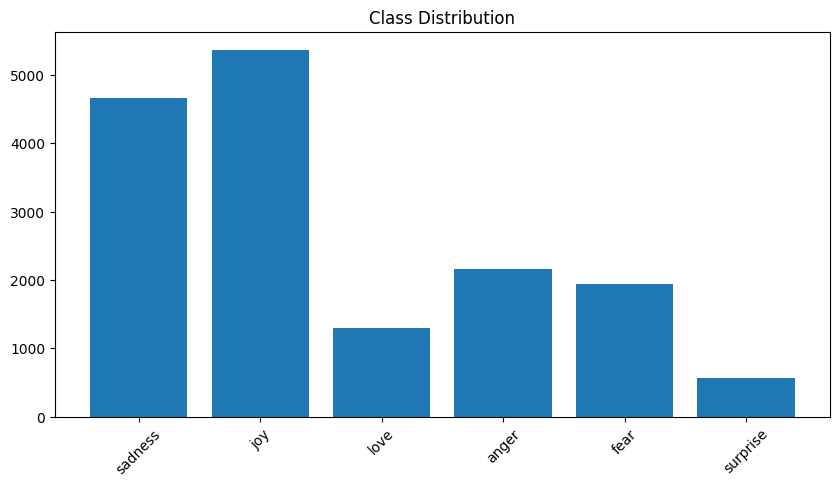


Average text length: 19.2 words
95th percentile length: 41.0 words


In [37]:
# Load dataset
dataset = load_dataset(Config.DATASET_NAME)

# Explore data
print("\n===== Dataset Structure =====")
print(dataset)

print("\n===== Label Distribution =====")
label_counts = Counter(dataset["train"][Config.LABEL_FIELD])
print({Config.LABEL_NAMES[k]: v for k, v in label_counts.items()})

# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(Config.LABEL_NAMES, [label_counts[i] for i in range(6)])
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Text length analysis
text_lengths = [len(text.split()) for text in dataset["train"][Config.TEXT_FIELD]]
print(f"\nAverage text length: {np.mean(text_lengths):.1f} words")
print(f"95th percentile length: {np.percentile(text_lengths, 95)} words")


In [42]:
# Preprocessing & Tokenization
tokenizer = BertTokenizer.from_pretrained(Config.MODEL_NAME)

def preprocess(batch):
    # Tokenize and convert to tensors
    encoded = tokenizer(
        batch[Config.TEXT_FIELD],
        padding="max_length",
        truncation=True,
        max_length=Config.MAX_LENGTH,
        return_tensors="pt",
        return_token_type_ids=False
    )

    # Convert to numpy arrays for Dataset compatibility
    return {
        "input_ids": encoded["input_ids"].squeeze().numpy(),
        "attention_mask": encoded["attention_mask"].squeeze().numpy(),
        "labels": batch[Config.LABEL_FIELD]
    }


In [43]:
# Apply preprocessing
dataset = dataset.map(preprocess, batched=True, batch_size=32)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [45]:
# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]),
            "attention_mask": torch.tensor(self.attention_mask[idx]),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = EmotionDataset(dataset["train"])
val_dataset = EmotionDataset(dataset["validation"])
test_dataset = EmotionDataset(dataset["test"])

# Calculate class weights
class_counts = torch.tensor([label_counts[i] for i in range(6)])
class_weights = (1.0 / class_counts) * class_counts.sum() / 2.0


In [46]:
# Verify tokenization again
sample = train_dataset[0]
print("\nTokenized Sample:")
print(f"Input IDs shape: {sample['input_ids'].shape}")  # Should be torch.Size([64])
print(f"Decoded text: {tokenizer.decode(sample['input_ids'])}")



Tokenized Sample:
Input IDs shape: torch.Size([64])
Decoded text: [CLS] i didnt feel humiliated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [47]:
# Create loaders
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)


In [50]:
def train():
    best_val_loss = float("inf")
    writer = SummaryWriter(Config.LOG_DIR)

    for epoch in range(Config.EPOCHS):
        # Training
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")

        for batch in progress_bar:
            optimizer.zero_grad()

            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch["labels"])

            accelerator.backward(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        avg_train_loss = total_loss / len(train_loader)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Validation
        model.eval()
        val_loss = 0
        preds, true_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                outputs = model(**batch)
                loss = loss_fn(outputs.logits, batch["labels"])
                val_loss += loss.item()

                preds.append(accelerator.gather(outputs.logits.argmax(dim=1)))
                true_labels.append(accelerator.gather(batch["labels"]))

        avg_val_loss = val_loss / len(val_loader)
        preds = torch.cat(preds).cpu().numpy()
        true_labels = torch.cat(true_labels).cpu().numpy()

        val_acc = accuracy_score(true_labels, preds)
        val_f1 = f1_score(true_labels, preds, average="macro")

        writer.add_scalar("Loss/Val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        writer.add_scalar("F1/Val", val_f1, epoch)

        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            accelerator.save_state(output_dir=os.path.join(Config.CHECKPOINT_DIR, "best_model"))

    writer.close()


In [48]:
# Initialize accelerator
accelerator = Accelerator()

# Model with class weights
model = BertForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS
)
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

# Prepare with accelerator
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model, optimizer, train_loader, val_loader
)

# Scheduler
total_steps = len(train_loader) * Config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=Config.WARMUP_STEPS,
    num_training_steps=total_steps
)

# Loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(accelerator.device))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
# Start training
train()


Epoch 1/5: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s, loss=0.0953]



Epoch 1:
Train Loss: 0.3107 | Val Loss: 0.1977
Val Acc: 0.9285 | Val F1: 0.9080


Epoch 2/5: 100%|██████████| 500/500 [02:56<00:00,  2.83it/s, loss=0.0583]



Epoch 2:
Train Loss: 0.1680 | Val Loss: 0.1670
Val Acc: 0.9360 | Val F1: 0.9144


Epoch 3/5: 100%|██████████| 500/500 [02:56<00:00,  2.83it/s, loss=0.159]



Epoch 3:
Train Loss: 0.1171 | Val Loss: 0.1735
Val Acc: 0.9350 | Val F1: 0.9125


Epoch 4/5: 100%|██████████| 500/500 [02:55<00:00,  2.84it/s, loss=0.00382]



Epoch 4:
Train Loss: 0.0918 | Val Loss: 0.2162
Val Acc: 0.9350 | Val F1: 0.9122


Epoch 5/5: 100%|██████████| 500/500 [02:55<00:00,  2.85it/s, loss=0.00937]



Epoch 5:
Train Loss: 0.0713 | Val Loss: 0.2240
Val Acc: 0.9340 | Val F1: 0.9110


In [60]:
# Dataset & Class Weights
# Calculate class weights once and reuse
label_counts = Counter(dataset["train"][Config.LABEL_FIELD])
class_counts = torch.tensor([label_counts[i] for i in range(6)])
class_weights = (1.0 / class_counts) * class_counts.sum() / 2.0

# Evaluation
def evaluate():
    # Initialize accelerator
    accelerator = Accelerator()

    # Load model architecture
    model = BertForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS
    )

    # Prepare components
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
    model, test_loader = accelerator.prepare(model, test_loader)

    # Load trained weights
    accelerator.load_state(os.path.join(Config.CHECKPOINT_DIR, "best_model"))

    # Initialize loss with global class weights
    loss_fn = torch.nn.CrossEntropyLoss(
        weight=class_weights.to(accelerator.device)
    )

    # Evaluation logic
    model.eval()
    test_loss = 0
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch["labels"])
            test_loss += loss.item()

            preds.append(accelerator.gather(outputs.logits.argmax(dim=1)))
            true_labels.append(accelerator.gather(batch["labels"]))

    # Convert to numpy
    preds = torch.cat(preds).cpu().numpy()
    true_labels = torch.cat(true_labels).cpu().numpy()

    print("\n===== Final Test Results =====")
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Accuracy: {accuracy_score(true_labels, preds):.4f}")
    print(f"Macro F1: {f1_score(true_labels, preds, average='macro'):.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, preds, target_names=Config.LABEL_NAMES))

evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Final Test Results =====
Test Loss: 0.1999
Accuracy: 0.9235
Macro F1: 0.8840

Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.95      0.96       581
         joy       0.98      0.91      0.95       695
        love       0.75      0.97      0.85       159
       anger       0.92      0.92      0.92       275
        fear       0.87      0.90      0.89       224
    surprise       0.70      0.80      0.75        66

    accuracy                           0.92      2000
   macro avg       0.87      0.91      0.88      2000
weighted avg       0.93      0.92      0.93      2000



In [65]:
# Prediction function
def predict(text):
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=Config.MAX_LENGTH,
        return_tensors="pt"
    ).to(accelerator.device)

    with torch.no_grad():
        outputs = model(**inputs)

    pred_label = outputs.logits.argmax().item()
    return Config.LABEL_NAMES[pred_label]

# Test examples
print("\nTest Predictions:")
print("Text: 'I feel so happy today!' →", predict("I feel so happy today!"))
print("Text: 'This situation terrifies me' →", predict("This situation terrifies me"))



Test Predictions:
Text: 'I feel so happy today!' → joy
Text: 'This situation terrifies me' → anger
